In [ ]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip install -q eli5
!pip install -q spacy
!python -m spacy download en

In [72]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d1-5FwxK53ePwygNWeG7jhsOWZbi5HOv'})
downloaded.GetContentFile('train_docs.pkl')

downloaded = drive.CreateFile({'id': '1MMOY477t965G0C5DtXeREVp0X85UaNq5'})
downloaded.GetContentFile('test_docs.pkl')

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import eli5
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import spacy
from spacy import displacy
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import Counter

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

# Анализ тональности текста

Будем классифицировать отзывы с IMDB на положительные/отрицательные

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [74]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [75]:
train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


In [76]:
positive_words = ('love', 'great', 'best', '7/10', '810', 'refreshing', 'wonderfully', 'funniest',
                  'erotic', 'excellent', 'carrey', 'flawless', 'hooked',
                  'superb', 'perfect', 'subtle', 'highly', 'vengeance',
                  'incredible', 'surprisingly', 'perfectly', 'rare', 'driven',
                  'finest', 'australia', 'touching', 'favorite', 'appreciated',
                  'chavez', 'enjoyable', 'scariest', '9/10', 'underrated',
                  '10/10', 'amazing', 'steals', 'tears', 'whoopi', 'delightful',
                  'flight', 'squirrel', 'units', 'kitty', 'enjoyed',
                  'dealing', 'bound')

negative_words = ('4/10', 'disappointment', '3/10', 'waste', 'poorly', 'worst', 'lacks',
                   '2/10','laughable', 'fails', 'awful', 'avoid', 'boring',
                   'disappointing', 'forgettable', '2/10', 'alright', 'unfunny',
                   'pointless', 'mediocre', 'lame', 'save', 'lousy', 'mst3k',
                   'horrible', 'badly', 'wooden', 'weak', 'baldwin', 'redeeming',
                   'mildly', 'dull', 'worse', 'mess', 'dreadful', 'britney',
                   '1/10', 'annoying', 'unwatchable', 'photo', 'poor', 'generous',
                   'sources', 'terrible', 'bored', 'boredom', 'insult', 'wonder',
                   'uninteresting', 'ridiculous', 'cardboard', 'unfortunately',
                   'miscast', 'ludicrous', 'refer', 'hoping', 'obnoxious', 'basically')


positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))

is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))

Test accuracy = 75.72%


Напишем регулярку, которая будет удалять `<br /><br />`

In [77]:
pattern = re.compile('<br\s?\/>|<br>')

print(train_df['review'].iloc[1])
print(pattern.subn(' ', train_df['review'].iloc[1])[0])

This show comes up with interesting locations as fast as the travel channel. It is billed as reality but in actuality it is pure prime time soap opera. It's tries to use exotic locales as a facade to bring people into a phony contest & then proceeds to hook viewers on the contestants soap opera style.<br /><br />It also borrows from an early CBS game show pioneer- Beat The Clock- by inventing situations for its contestants to try & overcome. Then it rewards the winner money. If they can spice it up with a little interaction between the characters, even better. While the game format is in slow motion versus Beat The Clock- the real accomplishment of this series is to escape reality. <br /><br />This show has elements of several types of successful past programs. Reality television, hardly, but if your hooked on the contestants, locale or contest, this is your cup of tea. If your not, this entire series is as I say, drivel dripping with gravy. It is another show hiding behind the reality

In [78]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Выполним дополнительную предобработку текста

In [79]:
nltk.download('stopwords')
tokenizer = nltk.tokenize.WordPunctTokenizer()
mystopwords = stopwords.words("english") + ['the', 'a']

def remove_punktuation(text):
    return re.sub(r'[^\w\s\d]', '', text)

def lower_case(text):
    text = str(text).lower()
    return ' '.join(tokenizer.tokenize(text))

def remove_stopwords(text):
    text = tokenizer.tokenize(text)
    text = [w for w in text if w not in mystopwords]
    return ' '.join(text)

def normalize(text):
    text = remove_punktuation(text)
    text = lower_case(text)
    text = remove_stopwords(text)
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [80]:
%%time

train_df['review'] = train_df['review'].apply(normalize)
test_df['review'] = test_df['review'].apply(normalize)

CPU times: user 25.3 s, sys: 60.7 ms, total: 25.3 s
Wall time: 34.2 s


Представим текст в виде мешка слов. Посмотрим на примере

In [81]:
vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names_out())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful' 'excellent' 'movie' 'the' 'was']


Теперь запустим на реальных данных

In [82]:
vectorizer.fit(train_df['review'].values)

CountVectorizer()

In [83]:
vectorizer.get_feature_names_out()

array(['00', '000', '0000000000001', ..., 'überannoying', 'überspy',
       'üvegtigris'], dtype=object)

Что-нибудь сгенерируем и получим на выходе вектор с мешком слов

In [84]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x111517 sparse matrix of type '<class 'numpy.int64'>'
	with 157 stored elements in Compressed Sparse Row format>

In [85]:
dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names_out())
print(classifier.coef_)

['awful' 'excellent' 'movie' 'the' 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


Получилось отлично, теперь запустим на реальных данных

In [86]:
model.fit(train_df['review'], train_df['is_positive'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [87]:
def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

eval_model(model, test_df)

Test accuracy = 86.99%


In [88]:
eli5.show_weights(classifier, vec=vectorizer, top=10)

In [89]:
def print_pred(idx):
    print('Positive' if test_df['is_positive'].iloc[idx] else 'Negative')
    eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer,
                        targets=['positive'], target_names=['negative', 'positive'])

In [90]:
print_pred(1)

Positive


In [91]:
print_pred(6)

Negative


Пример неправильной классификации

In [92]:
preds_vount_vect = model.predict(test_df['review'])

incorrect_pred_index = np.random.choice(np.where(preds_vount_vect != test_df['is_positive'])[0])

eli5.show_prediction(classifier,
                     test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer,
                     targets=['positive'],
                     target_names=['negative', 'positive'])

# TF-IDF

In [93]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([('vectorizer', vectorizer),
                ('classifier', classifier)])

model.fit(train_df['review'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 88.58%


In [94]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+7.220,x42423
+6.295,x33753
+5.262,x11233
+4.709,x73906
+4.676,x109368
+4.232,x5336
+4.230,x107699
+4.209,x35574
+4.096,x58606
+3.857,x58632


In [95]:
print_pred(1)

Positive


In [96]:
print_pred(6)

Negative


 # N-граммы слов

In [97]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([('vectorizer', vectorizer),
                ('classifier', classifier)])

model.fit(train_df['review'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 88.28%


In [98]:
vectorizer = TfidfVectorizer(ngram_range=(1, 4))
classifier = LogisticRegression()

model = Pipeline([('vectorizer', vectorizer),
                ('classifier', classifier)])

model.fit(train_df['review'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 87.04%


# N-граммы символов

In [99]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6),
                             max_features=20_000,
                             analyzer='char')
classifier = LogisticRegression()

model = Pipeline([('vectorizer', vectorizer),
                ('classifier', classifier)])

model.fit(train_df['review'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 87.56%


In [100]:
print_pred(1)

Positive


In [101]:
vectorizer = TfidfVectorizer(ngram_range=(3, 7),
                             max_features=20_000,
                             analyzer='char')
classifier = LogisticRegression()

model = Pipeline([('vectorizer', vectorizer),
                ('classifier', classifier)])

model.fit(train_df['review'], train_df['is_positive'])
eval_model(model, test_df)

Test accuracy = 87.66%


In [102]:
print_pred(1)

Positive


# Лемматизация

In [103]:
nlp = spacy.load('en_core_web_sm', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [104]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

dreamgirls dreamgirl B ORG
despite despite O 
fistful fistful O 
tony tony O 
wins win O 
incredibly incredibly O 
weak weak O 
year year B DATE
broadway broadway O 
never never O 
one one O 
would would O 
call call O 
jewel jewel B PERSON
crown crown I PERSON
stage stage O 
musicals musical O 
however however O 
say say O 
right right O 
cinematic cinematic O 
hands hand O 
could could O 
fleshed fleshed O 
polished polished O 
something something O 
worthwhile worthwhile O 
onscreen onscreen O 
unfortunately unfortunately O 
transfers transfer O 
screen screen O 
basically basically O 
slavishly slavishly O 
faithful faithful O 
version version O 
stage stage O 
hit hit O 
inherent inherent O 
weaknesses weakness O 
intact intact O 
first first B ORDINAL
score score O 
never never O 
one one O 
strong strong O 
points point O 
production production O 
film film O 
change change O 
factor factor O 
lots lot O 
songs song O 
perhaps perhaps O 
many many O 
especially especially O 
mem

In [105]:
lemmatizer = WordNetLemmatizer()

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [106]:
def lemmatized_words(text):
    text_lem = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)]
    return ' '.join(word for word in text_lem)

In [107]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [108]:
train_df['lemmatized'] = train_df['review'].apply(lemmatized_words)
test_df['lemmatized'] = test_df['review'].apply(lemmatized_words)

In [109]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['lemmatized'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.97%


# Стёмминг

In [110]:
stemmer = PorterStemmer()

In [111]:
def stemmed_words(text):
    text_stem = [stemmer.stem(word) for word in tokenizer.tokenize(text)]
    return ' '.join(word for word in text_stem)

In [112]:
train_df['stemmed'] = train_df['review'].apply(stemmed_words)
test_df['stemmed'] = test_df['review'].apply(stemmed_words)

In [113]:
model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['stemmed'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 82.37%


Посмотрим по гистограмме какая длина нам подходит

<BarContainer object of 253 artists>

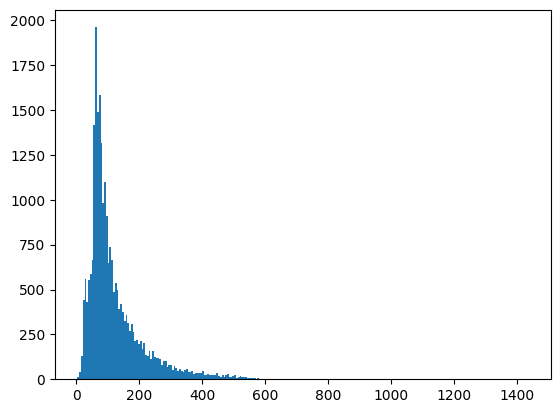

In [114]:
_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Перенумеруем слова

In [115]:
words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break

    word2idx[word] = len(word2idx)

print('Words count', len(word2idx))

Words count 20441


In [116]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int32)

    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0] * (max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int32)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

In [117]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 64)          1308224   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,308,995
Trainable params: 1,308,995
Non-trainable params: 0
____________________________________________

In [118]:
model.fit(X_train,
          train_df['is_positive'],
          batch_size=128,
          epochs=5,
          validation_data=(X_test, test_df['is_positive']))

Epoch 1/5
196/196 [==============================] - 14s 67ms/step - loss: 0.5833 - accuracy: 0.7336 - val_loss: 0.3832 - val_accuracy: 0.8534
Epoch 2/5
196/196 [==============================] - 12s 61ms/step - loss: 0.2776 - accuracy: 0.8913 - val_loss: 0.2882 - val_accuracy: 0.8791
Epoch 3/5
196/196 [==============================] - 12s 60ms/step - loss: 0.1703 - accuracy: 0.9385 - val_loss: 0.2876 - val_accuracy: 0.8809
Epoch 4/5
196/196 [==============================] - 12s 60ms/step - loss: 0.0992 - accuracy: 0.9698 - val_loss: 0.3119 - val_accuracy: 0.8782
Epoch 5/5
196/196 [==============================] - 12s 60ms/step - loss: 0.0515 - accuracy: 0.9880 - val_loss: 0.3552 - val_accuracy: 0.8718


Подсчитаем качество модели на тесте

In [119]:
model.evaluate(X_test, test_df['is_positive'])

782/782 [==============================] - 2s 2ms/step - loss: 0.3552 - accuracy: 0.8718


[0.35522356629371643, 0.8717600107192993]

In [120]:
X_train = convert(train_df['lemmatized'], word2idx, 1000)
X_test = convert(test_df['lemmatized'], word2idx, 1000)

In [121]:
model.fit(X_train,
          train_df['is_positive'],
          batch_size=128,
          epochs=5,
          validation_data=(X_test, test_df['is_positive']))

Epoch 1/5
196/196 [==============================] - 12s 62ms/step - loss: 0.0561 - accuracy: 0.9829 - val_loss: 0.4185 - val_accuracy: 0.8585
Epoch 2/5
196/196 [==============================] - 12s 61ms/step - loss: 0.0196 - accuracy: 0.9973 - val_loss: 0.4534 - val_accuracy: 0.8596
Epoch 3/5
196/196 [==============================] - 12s 61ms/step - loss: 0.0079 - accuracy: 0.9995 - val_loss: 0.4806 - val_accuracy: 0.8615
Epoch 4/5
196/196 [==============================] - 12s 61ms/step - loss: 0.0046 - accuracy: 0.9997 - val_loss: 0.5045 - val_accuracy: 0.8609
Epoch 5/5
196/196 [==============================] - 12s 62ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.5272 - val_accuracy: 0.8603


In [122]:
model.evaluate(X_test, test_df['is_positive'])

782/782 [==============================] - 2s 2ms/step - loss: 0.5272 - accuracy: 0.8603


[0.5271857380867004, 0.860319972038269]

In [123]:
X_train = convert(train_df['stemmed'], word2idx, 1000)
X_test = convert(test_df['stemmed'], word2idx, 1000)

In [124]:
model.fit(X_train,
          train_df['is_positive'],
          batch_size=128,
          epochs=5,
          validation_data=(X_test, test_df['is_positive']))

Epoch 1/5
196/196 [==============================] - 12s 62ms/step - loss: 0.2644 - accuracy: 0.8982 - val_loss: 0.4531 - val_accuracy: 0.8184
Epoch 2/5
196/196 [==============================] - 12s 60ms/step - loss: 0.1168 - accuracy: 0.9608 - val_loss: 0.5104 - val_accuracy: 0.8156
Epoch 3/5
196/196 [==============================] - 12s 61ms/step - loss: 0.0662 - accuracy: 0.9825 - val_loss: 0.5961 - val_accuracy: 0.8108
Epoch 4/5
196/196 [==============================] - 12s 64ms/step - loss: 0.0357 - accuracy: 0.9928 - val_loss: 0.6884 - val_accuracy: 0.8118
Epoch 5/5
196/196 [==============================] - 12s 62ms/step - loss: 0.0152 - accuracy: 0.9980 - val_loss: 0.7642 - val_accuracy: 0.8086


In [125]:
model.evaluate(X_test, test_df['is_positive'])

782/782 [==============================] - 2s 2ms/step - loss: 0.7642 - accuracy: 0.8086


[0.7642181515693665, 0.8086400032043457]